In [5]:
import nibabel as nib
import os
from pathlib import Path
import matplotlib.pyplot as plt

PATH = "/home/muhamed/mntdrive/zips/FDG-PET-CT-Lesions/PETCT_4d7b745a7b/01-23-2003-NA-PET-CT Ganzkoerper  primaer mit KM-29523"

In [6]:
pths = [os.path.join(Path(PATH), p) for p in os.listdir(PATH)]

In [7]:
nibs=[]
for pth in pths:
    nibs.append(nib.load(pth))

In [8]:
pths

['/home/muhamed/mntdrive/zips/FDG-PET-CT-Lesions/PETCT_4d7b745a7b/01-23-2003-NA-PET-CT Ganzkoerper  primaer mit KM-29523/CT.nii.gz',
 '/home/muhamed/mntdrive/zips/FDG-PET-CT-Lesions/PETCT_4d7b745a7b/01-23-2003-NA-PET-CT Ganzkoerper  primaer mit KM-29523/CTres.nii.gz',
 '/home/muhamed/mntdrive/zips/FDG-PET-CT-Lesions/PETCT_4d7b745a7b/01-23-2003-NA-PET-CT Ganzkoerper  primaer mit KM-29523/PET.nii.gz',
 '/home/muhamed/mntdrive/zips/FDG-PET-CT-Lesions/PETCT_4d7b745a7b/01-23-2003-NA-PET-CT Ganzkoerper  primaer mit KM-29523/SEG.nii.gz',
 '/home/muhamed/mntdrive/zips/FDG-PET-CT-Lesions/PETCT_4d7b745a7b/01-23-2003-NA-PET-CT Ganzkoerper  primaer mit KM-29523/SUV.nii.gz']

Text(0.5, 1.0, 'CT')

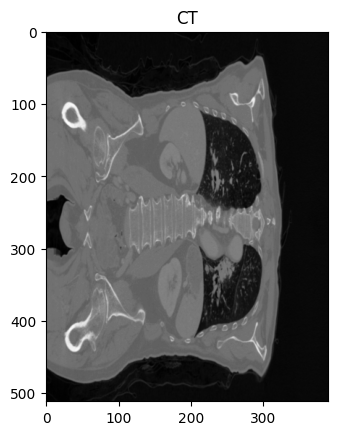

In [9]:

plt.imshow(nibs[0].get_fdata()[:, 200, :], cmap="gray")
plt.title("CT")

In [10]:
nibs[1].shape

(400, 400, 326)

In [11]:
nibs[1].affine

array([[-2.03642011e+00,  0.00000000e+00,  0.00000000e+00,
         4.06738007e+02],
       [-0.00000000e+00,  2.03642011e+00,  0.00000000e+00,
        -1.99048584e+02],
       [ 0.00000000e+00, -0.00000000e+00,  3.00000000e+00,
        -1.21950000e+03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

Text(0.5, 1.0, 'CT res')

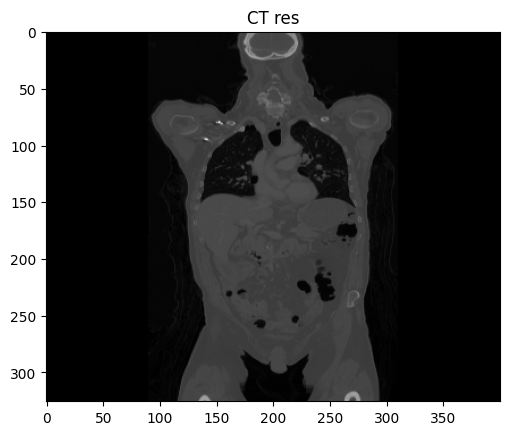

In [12]:
import numpy as np
plt.imshow(np.rot90(nibs[1].get_fdata()[:, 200, :]), cmap='gray')
plt.title("CT res")

Text(0.5, 1.0, 'PET')

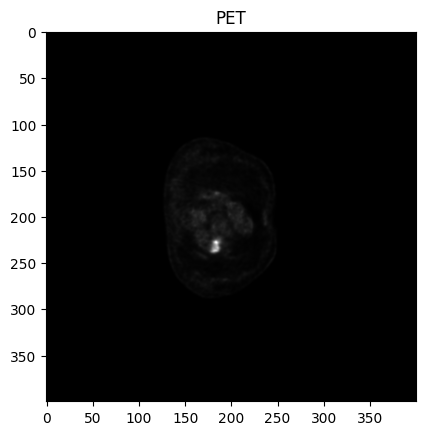

In [13]:
plt.imshow(nibs[2].get_fdata()[:, :, 200], cmap="gray")
plt.title("PET")

Text(0.5, 1.0, 'SUV')

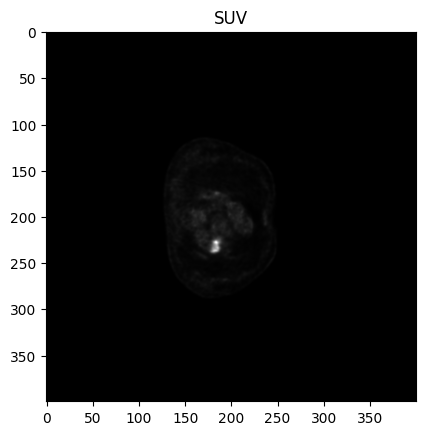

In [15]:
plt.imshow(nibs[4].get_fdata()[:, :, 200], cmap="gray")
plt.title("SUV")

In [17]:
pths

['/home/muhamed/mntdrive/zips/FDG-PET-CT-Lesions/PETCT_4d7b745a7b/01-23-2003-NA-PET-CT Ganzkoerper  primaer mit KM-29523/CT.nii.gz',
 '/home/muhamed/mntdrive/zips/FDG-PET-CT-Lesions/PETCT_4d7b745a7b/01-23-2003-NA-PET-CT Ganzkoerper  primaer mit KM-29523/CTres.nii.gz',
 '/home/muhamed/mntdrive/zips/FDG-PET-CT-Lesions/PETCT_4d7b745a7b/01-23-2003-NA-PET-CT Ganzkoerper  primaer mit KM-29523/PET.nii.gz',
 '/home/muhamed/mntdrive/zips/FDG-PET-CT-Lesions/PETCT_4d7b745a7b/01-23-2003-NA-PET-CT Ganzkoerper  primaer mit KM-29523/SEG.nii.gz',
 '/home/muhamed/mntdrive/zips/FDG-PET-CT-Lesions/PETCT_4d7b745a7b/01-23-2003-NA-PET-CT Ganzkoerper  primaer mit KM-29523/SUV.nii.gz']

Text(0.5, 1.0, 'mask')

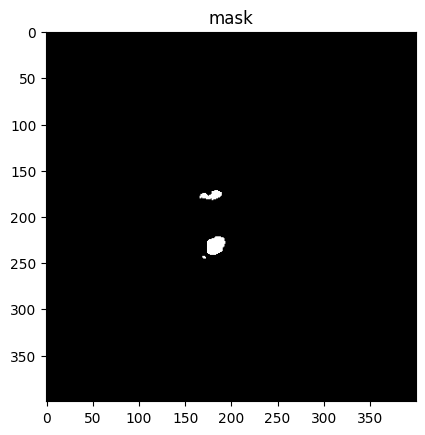

In [18]:
plt.imshow(nibs[3].get_fdata()[:, :, 200], cmap="gray")
plt.title("mask")

In [ ]:
import os
import torch
import nibabel as nib
from torch.utils.data import Dataset
import numpy as np


class PETCTDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (str): Root directory containing patients.
            transform (callable, optional): Function to apply to all volumes (pet, ct, mask).
        """
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []

        for patient in os.listdir(root_dir):
            patient_path = os.path.join(root_dir, patient)
            if not os.path.isdir(patient_path):
                continue
            for study in os.listdir(patient_path):
                study_path = os.path.join(patient_path, study)
                if not os.path.isdir(study_path):
                    continue

                nii_files = [f for f in os.listdir(study_path) if f.endswith('.nii.gz')]

                pet_file = next((f for f in nii_files if 'pet' in f.lower()), None)
                ct_file = next((f for f in nii_files if 'ctres' in f.lower()), None)
                mask_file = next((f for f in nii_files if 'seg' in f.lower()), None)

                if pet_file and ct_file:
                    self.samples.append({
                        'pet_path': os.path.join(study_path, pet_file),
                        'ct_path': os.path.join(study_path, ct_file),
                        'mask_path': os.path.join(study_path, mask_file) if mask_file else None,
                    })

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]

        pet_vol = nib.load(sample['pet_path']).get_fdata().astype(np.float32)
        ct_vol = nib.load(sample['ct_path']).get_fdata().astype(np.float32)

        # Normalize PET and CT
        pet_vol = (pet_vol - pet_vol.min()) / (pet_vol.ptp() + 1e-6)
        ct_vol = (ct_vol - ct_vol.min()) / (ct_vol.ptp() + 1e-6)

        # Optional: Clip extreme values if needed

        # Load mask (if exists)
        if sample['mask_path'] is not None:
            mask_vol = nib.load(sample['mask_path']).get_fdata().astype(np.float32)
        else:
            mask_vol = np.zeros_like(ct_vol, dtype=np.float32)

        # Convert to tensors with shape [1, D, H, W]
        pet_tensor = torch.from_numpy(pet_vol).unsqueeze(0)
        ct_tensor = torch.from_numpy(ct_vol).unsqueeze(0)
        mask_tensor = torch.from_numpy(mask_vol).unsqueeze(0)

        if self.transform:
            pet_tensor, ct_tensor, mask_tensor = self.transform(pet_tensor, ct_tensor, mask_tensor)

        return ct_tensor, pet_tensor, mask_tensor


In [91]:
ds = PETCTDataset(PATH)
from torch.utils.data import DataLoader
dataloader = DataLoader(ds, batch_size=1, shuffle=True)

for ct, pet, mask in dataloader:
    print(ct.shape, pet.shape, mask.shape)  # [B, 1, D, H, W]
    print(ct.min(), ct.max())
    print(mask.min(), mask.max())
    print(pet.min(), pet.max())
    break

torch.Size([1, 1, 400, 400, 326]) torch.Size([1, 1, 400, 400, 326]) torch.Size([1, 1, 400, 400, 326])
tensor(0.) tensor(1.)
tensor(0.) tensor(1.)
tensor(0.) tensor(1.)
